In [34]:
import json
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib import cm
import numpy as np
import sympy
import torch
import torch.nn as nn
import torch.nn.functional as F

In [35]:
infile = open('FEM_converted.json', 'r')

In [36]:
var_dict = json.load(infile)

In [37]:
infile.close()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
nnode = var_dict["nnode"]
xcoord = np.asarray([i[0] for i in var_dict["coord"]])
ycoord = np.asarray([i[1] for i in var_dict["coord"]])
nelem = var_dict["nelem"]
connect = var_dict["connect"]
nfix = var_dict["nfix"]
fixnodes = var_dict["fixnodes"]
ndload = var_dict["ndload"]
dloads = var_dict["dloads"]

In [40]:
def create_Dmat(E, nu):
    return (E/((1+nu)*(1-2*nu))) * torch.tensor([[1-nu,nu,0],[nu,1-nu,0],[0,0,(1-2*nu)/2]], device=device)

In [41]:
def elresid(xa, ya, xb, yb, tx, ty):
    length = np.sqrt((xa-xb)*(xa-xb)+(ya-yb)*(ya-yb))
    return torch.tensor([tx,ty,tx,ty], device=device)*length/2

In [42]:
def elstif(xa,ya,xb,yb,xc,yc,Dmat):
    # Define B matrix
    nax = -(yc-yb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nay =  (xc-xb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nbx = -(ya-yc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    nby =  (xa-xc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    ncx = -(yb-ya)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    ncy =  (xb-xa)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    area = (1/2)*np.abs( (xb-xa)*(yc-ya) - (xc-xa)*(yb-ya) )
    Bmat = torch.tensor([[nax, 0, nbx, 0, ncx, 0],
                        [0, nay, 0, nby, 0, ncy],
                        [nay, nax, nby, nbx, ncy, ncx]], device=device)
    
    # Return element stiffness
    return area * torch.transpose(Bmat, 0, 1).double() @ Dmat.double() @ Bmat.double()

In [43]:
class uFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Stif, resid):
        u = torch.linalg.solve(Stif, resid)
        StifInv = torch.linalg.inv(Stif)

        ctx.save_for_backward(Stif, resid, u, StifInv)

        return u

    @staticmethod
    def backward(ctx, grad_output):
        Stif, resid, u, StifInv = ctx.saved_tensors

        dStif = torch.zeros((2 * nnode, (2 * nnode)**2), device=device)
        k = 0

        for i in range(0, (2 * nnode)**2, 2*nnode):
            for j in range(2 * nnode):
                dStif[j][i + k] = resid[j]
            k = k + 1

        stridedStifInv = torch.zeros((2 * nnode, 2 * nnode), device=device)
        for i in range(2 * nnode):
            for j in range(2 * nnode):
                stridedStifInv[i][j] = StifInv[i][j]

        StifKron = torch.kron(stridedStifInv, torch.transpose(StifInv, 0, 1))

        return (grad_output @ dStif @ StifKron).reshape([10, 10]), None

In [44]:
createU = uFunction.apply

In [45]:
class steelAlNet(nn.Module):
    def __init__(self):
        super(steelAlNet, self).__init__()
        torch.manual_seed(12)
        self.elem_material = nn.Parameter(torch.rand(nelem, device=device), requires_grad=True)

    def forward(self):
        # Create customized NN layer
        #   input: Stif, resid
        #   output: u
        # Need to implement forward() and backward()
        #   forward() is essentially np.linalg.solve()
        #   backward()
        #       input: partial derivative of loss function with respect to u
        #       output: partial derivative of loss / input

        elem_weights = torch.zeros(nelem, device=device)

        Stif = torch.zeros((2*nnode, 2*nnode), device=device)

        for lmn in range(nelem):
            elem_weights[lmn] = 0.00513 / (1 + torch.exp(-15 * (self.elem_material[lmn] - 0.5))) + 0.0027

            a = connect[lmn][0]
            b = connect[lmn][1]
            c = connect[lmn][2]

            Young = 131 / (1 + torch.exp(-10 * (self.elem_material[lmn] - 0.5))) + 69
            nu = 0.03 / (1 + torch.exp(10 * (self.elem_material[lmn] - 0.5))) + 0.3

            Dmat = create_Dmat(Young, nu)
            k = elstif(xcoord[a], ycoord[a],
                        xcoord[b], ycoord[b],
                        xcoord[c], ycoord[c], Dmat)

            for i in range(3):
                for ii in range(2):
                    for j in range(3):
                        for jj in range(2):
                            rw = 2*(connect[lmn][i])+ii
                            cl = 2*(connect[lmn][j])+jj
                            Stif[rw][cl] = Stif[rw][cl] + k[2*i+ii][2*j+jj]
        
        resid = torch.zeros(2*nnode, device=device)

        pointer = [1, 2, 0]
        for i in range(ndload):
            lmn = dloads[i][0]
            face = dloads[i][1]
            a = connect[lmn][face]
            b = connect[lmn][pointer[face]]
            r = elresid(xcoord[a], ycoord[a],
                        xcoord[b], ycoord[b],
                        dloads[i][2], dloads[i][3])
            
            resid[2*a]=resid[2*a]+r[0]
            resid[2*a+1]=resid[2*a+1]+r[1]
            resid[2*b]=resid[2*b]+r[2]
            resid[2*b+1]=resid[2*b+1]+r[3]

        for i in range(nfix):
            rw=2*(fixnodes[i][0]) + fixnodes[i][1]
            for j in range(2*nnode):
                Stif[rw][j] = 0
            Stif[rw][rw] = 1.0
            resid[rw] = fixnodes[i][2]

        u = createU(Stif, resid)
    
        return self.elem_material, elem_weights, u


In [46]:
net = steelAlNet()
net.to(device)

steelAlNet()

In [47]:
def displayPlot(elem_material, u):
    uxcoord = [0] * nnode
    uycoord = [0] * nnode
    for i in range(nnode):
        uxcoord[i] = xcoord[i] + u[2*i].item()
        uycoord[i] = ycoord[i] + u[2*i+1].item()

    facecolors = [0] * nelem

    for lmn in range(nelem):
        if elem_material[lmn] > 0.5:
            facecolors[lmn] = 0
        else:
            facecolors[lmn] = 1
    
    fig, ax = plt.subplots()
    triang = mtri.Triangulation(xcoord, ycoord, connect)
    triang2 = mtri.Triangulation(uxcoord, uycoord, connect)
    plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='green', linewidth=2, cmap='Greys', alpha=0.5)
    plt.tripcolor(triang2, ax, facecolors=facecolors, edgecolors='r', linewidth=2, cmap='Greys', alpha=0.5)

Parameter containing:
tensor([0.0016, 0.0074, 0.2903, 0.8227], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0093,  0.0017,  0.1566,  0.8091], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0199, -0.0041,  0.1058,  0.7925], device='cuda:0',
       requires_grad=True)


C:\Users\hyech\AppData\Local\Temp\ipykernel_17592\2257136339.py:19: UserWarning: Positional parameter C has no effect when the keyword facecolors is given
  plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='green', linewidth=2, cmap='Greys', alpha=0.5)
C:\Users\hyech\AppData\Local\Temp\ipykernel_17592\2257136339.py:20: UserWarning: Positional parameter C has no effect when the keyword facecolors is given
  plt.tripcolor(triang2, ax, facecolors=facecolors, edgecolors='r', linewidth=2, cmap='Greys', alpha=0.5)


Parameter containing:
tensor([-0.0296, -0.0096,  0.0733,  0.7727], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0385, -0.0149,  0.0492,  0.7488], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0468, -0.0199,  0.0299,  0.7188], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0544, -0.0248,  0.0137,  0.6793], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-6.1603e-02, -2.9412e-02, -3.4029e-04,  6.2325e-01], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0685, -0.0339, -0.0129,  0.5349], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0753, -0.0384, -0.0247,  0.3798], device='cuda:0',
       requires_grad=True)


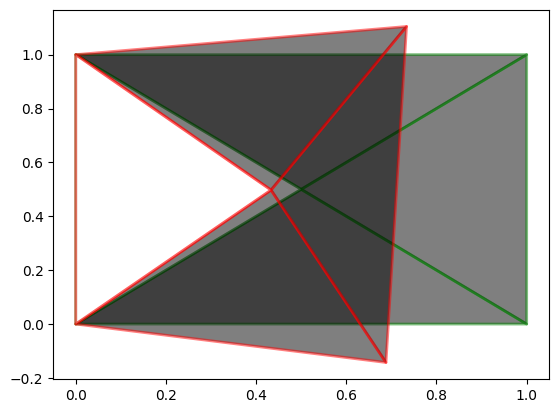

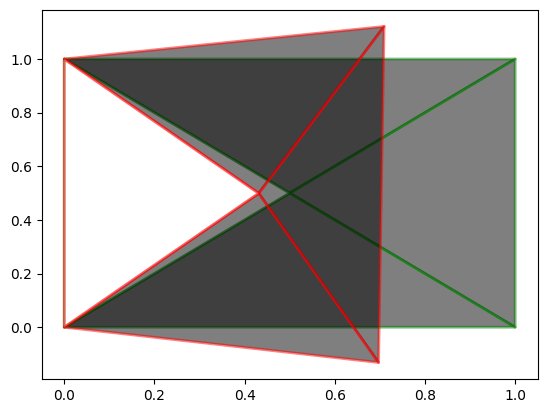

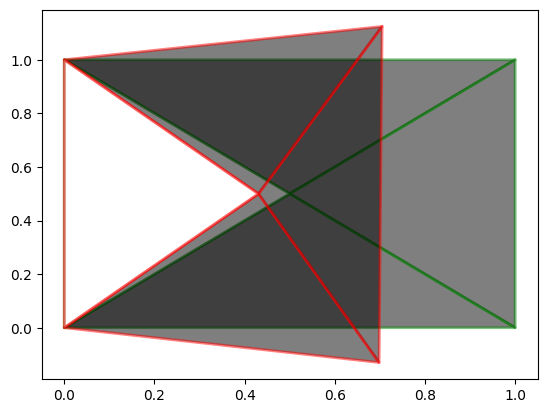

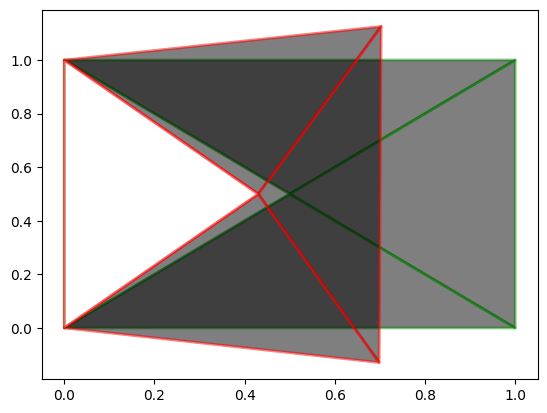

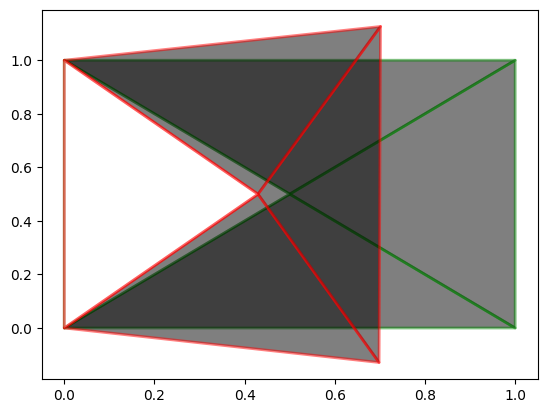

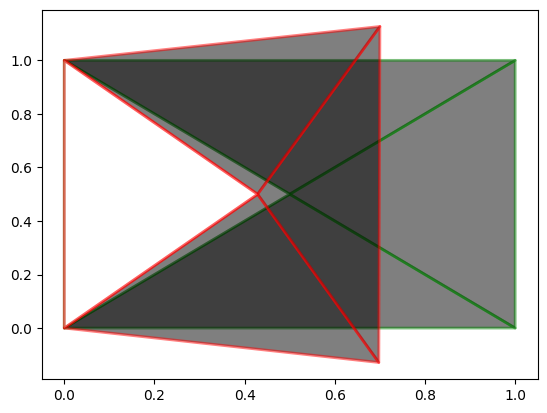

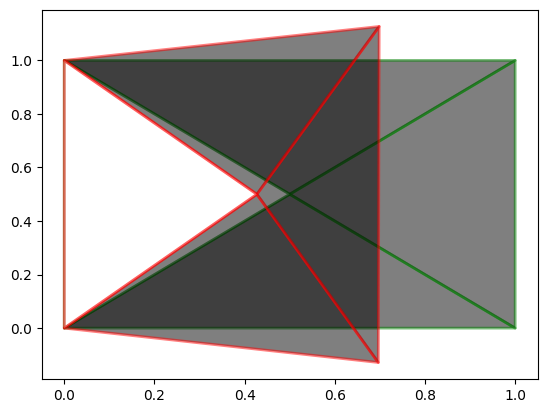

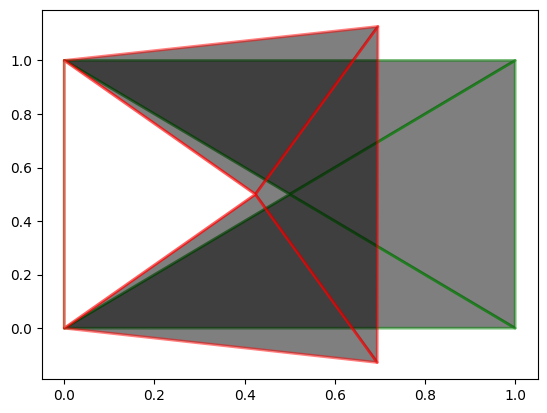

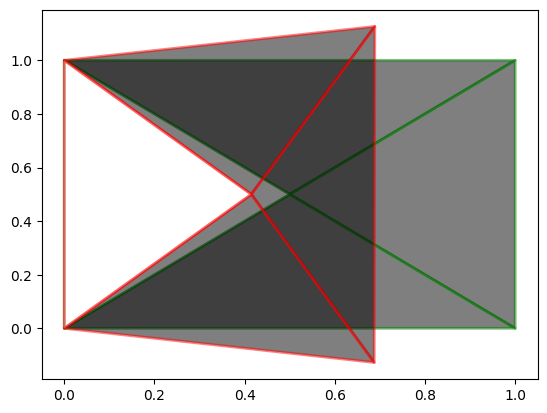

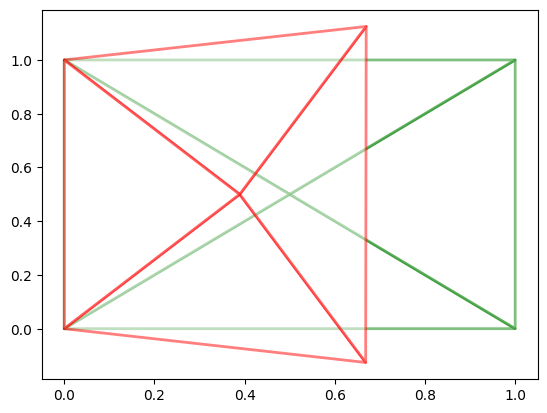

In [48]:
num_epochs = 10
learning_rate = 1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

ideal_weights = torch.tensor([0.0027] * nelem, device=device)
ideal_u = torch.tensor([0.0] * 2 * nnode, device=device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    elem_material, elem_weights, u = net()
    print(elem_material)

    displayPlot(elem_material, u)

    loss = loss_fn(u, ideal_u)
    loss.backward()

    loss2 = loss_fn(elem_weights, ideal_weights)
    loss2 = loss2 * 10
    loss2.backward()

    optimizer.step()

C:\Users\hyech\AppData\Local\Temp\ipykernel_17592\1853349126.py:13: UserWarning: Positional parameter C has no effect when the keyword facecolors is given
  plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='k', cmap='Greys', alpha=0.5)


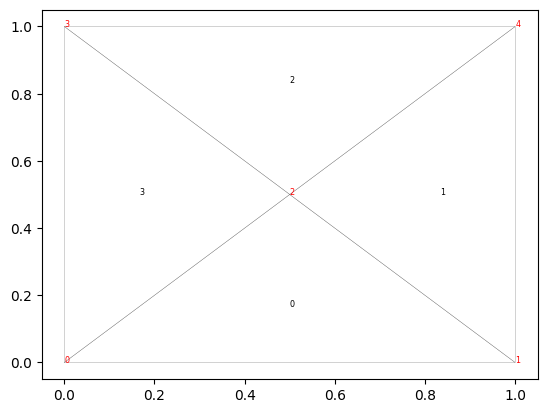

In [49]:
elem_material, elem_weights, u = net()

facecolors = [0] * nelem

for lmn in range(nelem):
    if elem_material[lmn] > 0.5:
        facecolors[lmn] = 0
    else:
        facecolors[lmn] = 1

fig, ax = plt.subplots()
triang = mtri.Triangulation(xcoord, ycoord, connect)
plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='k', cmap='Greys', alpha=0.5)
for i in range(nnode):
    plt.text(xcoord[i], ycoord[i], i, color='r', size='xx-small')
for i in range(nelem):
    n1, n2, n3 = connect[i]
    avgx = (xcoord[n1] + xcoord[n2] + xcoord[n3]) / 3
    avgy = (ycoord[n1] + ycoord[n2] + ycoord[n3]) / 3
    plt.text(avgx, avgy, i, size='xx-small')